# import

In [1]:
from Utilities.tracking_examples_functions import *

# load in example data
- the data is tracked so that there is a tracking point on the mouses head and on each of the 5 task ports
- .h5 file (DLC tracking output) is loaded and tracking point x y data is extracted 
- this data is filtered: low confidence tracking points (>98% confidence) are dropped and x y data is interpolated to fill the gaps

In [2]:
# load in example data 
for t_file in os.listdir(os.getcwd()+r'\\example_tracking_data\\'):
    if '.h5' in t_file:
        print(t_file)
        tracking_file = os.getcwd()+r'\example_tracking_data\\'+t_file
        back_head_centre,p1,p2,p3,p4,p5 = load_H5_bodypart_ports(tracking_file)
        back_tracking = (back_head_centre)
        port_tracking = ([p1,p2,p3,p4,p5])
        

EarlyTrainingEJT30video2020-01-16T14_48_36DLC_resnet50_Normal_tracking_back_and_portsApr25shuffle1_800000.h5


# find task relevant tracking periods
extract times mouse is close to each behavioural port

In [3]:
current_x = back_tracking.interped_x.values
current_y = back_tracking.interped_y.values
port_positions = []
for i in range(5):
    port = port_tracking[i]
    port_positions += [[np.median(port.interped_x),np.median(port.interped_y)]]
    
port_centroids = port_positions
    
coords = []
for ind_,item in enumerate(current_x):
    coords += [[item,current_y[ind_]]]

radius = 45
threshold_breaks = np.zeros(len(coords))
# for each port we care about find where the mouse breaks the distcance threshold
for ind_ in range(0,len(port_centroids)):
    threshold = radius
    target = port_centroids[ind_]
    closest,indicies = closest_points(target, coords, threshold)
    
    threshold_breaks[indicies] = ind_ + 1

# exclude (by labelling with -1) any times the trajetcory goes outside of the port area
half_dist = (port_centroids[0][-1] - port_centroids[4][-1])/2
exclusion_mask = (np.array(current_y) < (port_centroids[0][-1] + half_dist)) * (np.array(current_y) > (port_centroids[4][-1] - half_dist))
exclusion_inds = np.where(exclusion_mask == False)
threshold_breaks[exclusion_inds] = -1

# exclude (by labelling with -1) any times the trajetcory goes outside of the port area
half_dist = (port_centroids[1][0] - port_centroids[0][0])/2
exclusion_mask = (np.array(current_x) > (port_centroids[0][0] - half_dist)) * (np.array(current_x) < (port_centroids[4][0] + half_dist))
exclusion_inds = np.where(exclusion_mask == False)
threshold_breaks[exclusion_inds] = -1

## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
time_filter = 2 #in s
frame_filter = int(time_filter / (1/60))

# find port to port trajects 
we know when the mouse is close to each port, so find times when the mouse goes from port to port 

In [4]:

start_port = 5
end_port = 1
# T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,3,3,4)
T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,3,4,-1)

start_port = 1
end_port = 4
T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,-1,3,5)


start_port = 4
end_port = 3
T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)

start_port = 3
end_port = 5
T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,-1,4)

# find average port to port trajects
- now we have all the times the mouse did a port to port tracjectory
- take these traject lines and make them roughly equivalent by interpolating so they have the same number of trakcing points
- for each point in each trajectory find the average xy position to create an average trajectory line 


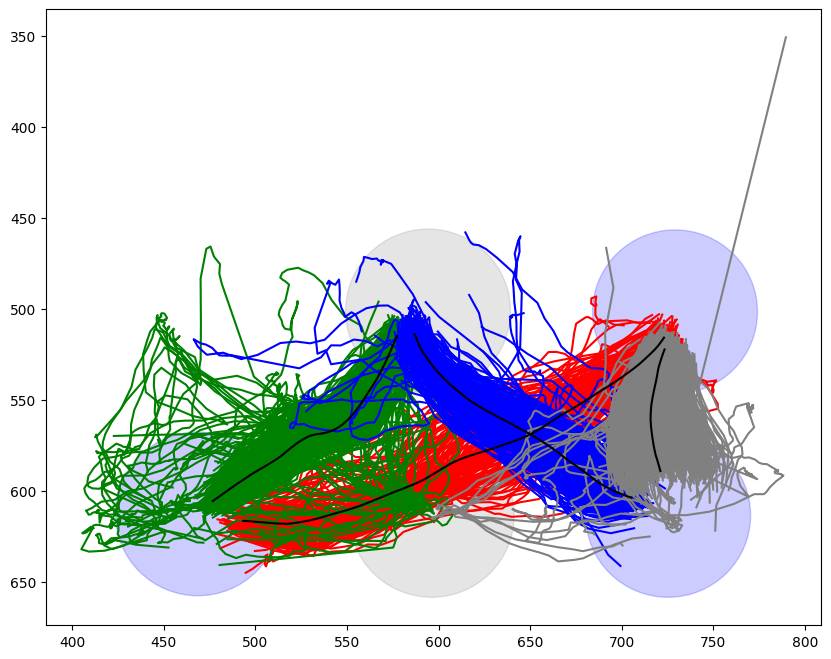

In [6]:

filtered_split_trajectories_x_positions = []
filtered_split_trajectories_y_positions = []
filtered_split_trajectories_frame_colors = []

# plot these filtered trajectories:

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(10, 8))

for ind, ax in enumerate(fig.axes):
    
    for index,port_centroid in enumerate(port_centroids):
        ## define rings around important ports: port 5, port2, port 3, port4
        radius = 45
        c = ['blue','grey','blue','grey','blue']
        circle1 = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
        ax.add_patch(circle1)

segment1 = plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,'red',current_x,current_y)
segment2 = plot_and_create_xy_segments(T2_start_ind,T2_end_ind,ax,'green',current_x,current_y)
segment3 = plot_and_create_xy_segments(T3_start_ind,T3_end_ind,ax,'blue',current_x,current_y)
segment4 = plot_and_create_xy_segments(T4_start_ind,T4_end_ind,ax,'grey',current_x,current_y)

a_curve1 = interpolate_to_longest_and_find_average_curve(segment1)
a_curve2 = interpolate_to_longest_and_find_average_curve(segment2)
a_curve3 = interpolate_to_longest_and_find_average_curve(segment3)
a_curve4 = interpolate_to_longest_and_find_average_curve(segment4)


x = [point[0] for point in a_curve1]
y = [point[1] for point in a_curve1]
ax.plot(x, y, '-', color ='black',alpha = 1)

x = [point[0] for point in a_curve2]
y = [point[1] for point in a_curve2]
ax.plot(x, y, '-', color ='black',alpha = 1)

x = [point[0] for point in a_curve3]
y = [point[1] for point in a_curve3]
ax.plot(x, y, '-', color ='black',alpha = 1)

x = [point[0] for point in a_curve4]
y = [point[1] for point in a_curve4]
ax.plot(x, y, '-', color ='black',alpha = 1)

ax.invert_yaxis()

# interpolate these average lines
- this gives us port - port segments made up of 1000s of individual points

  0%|          | 0/103 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:00<?, ?it/s]


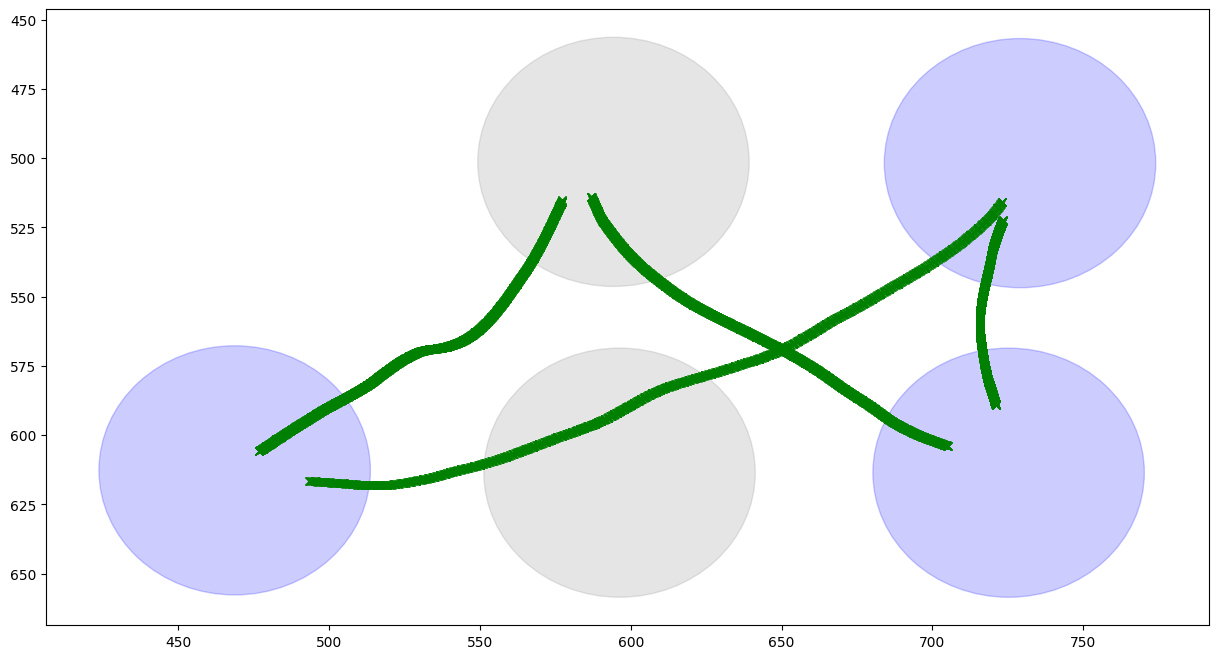

In [7]:
interpolated_av_curves = []

for a_curve_ in [a_curve1,a_curve2,a_curve3,a_curve4]:

    total_length = total_length_of_curve(a_curve_)
    # chose number of points you want to construct the curve out of - this will only be roughly fitted as the code does a lot of rounding. This cant be smaller than the current length - ifyou do this is will just keep the curve the same (it can only add points)
    num_points = 2000
    # number to multiply the segment length to get the rough breakdown so that we get around 1000 in total 
    segment_warp_factor = num_points/int(total_length) 


    interpolated_av_curve = []
    for i in tqdm(range(len(a_curve_))):
        if i>0:
            st_ = a_curve_[i]
            ed_ = a_curve_[i-1]
            seg_distance = math.dist(st_,ed_)
            num_points_to_add = np.round(seg_distance * segment_warp_factor)
            if num_points_to_add >1:

                seg = [st_] + [ed_]
                x = [point[0] for point in seg]
                y = [point[1] for point in seg]

                M = int(num_points_to_add)
                t = np.linspace(0, len(x), M)
                x_interp = np.interp(t, np.arange(len(x)), x)
                y_interp = np.interp(t, np.arange(len(y)), y)

                interpolated_av_curve += ([[x, y] for x, y in zip(x_interp, y_interp)])


            else:
                interpolated_av_curve += [a_curve_[i]]
                
                
    interpolated_av_curves += [interpolated_av_curve]

            
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    
    for index,port_centroid in enumerate(port_centroids):
        ## define rings around important ports: port 5, port2, port 3, port4
        radius = 45
        c = ['blue','grey','blue','grey','blue']
        circle1 = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
        ax.add_patch(circle1)
        
    ax.invert_yaxis()

    for interpolated_av_curve in interpolated_av_curves:
        x = [point[0] for point in interpolated_av_curve]
        y = [point[1] for point in interpolated_av_curve]
        ax.plot(x, y, 'x',color = 'green')
    



# determine deviation from average
- for each tracking point in each trajectory find the point on the relevant interpolated average line which it is closest to
- this gives us a list of distances (deviations) from the average for each trajectory line
- this can be used to find the standard devation of the average distance from the average line.
- this gives us a meausre of how steretyped the port-port trjectories were:
- stereotyped = similar to average line = smaller devation
- not stereotyped = different to average line = larger devation



In [8]:
median_dists1=[]
std_dists1 = []
for i in range(len(segment1)):
    index,dist = closest_point(segment1[i],interpolated_av_curves[0])
    median_dists1 += [np.median(dist)]
    std_dists1 += [np.std(dist)]


median_dists2=[]
std_dists2 = []
for i in range(len(segment2)):
    index,dist = closest_point(segment2[i],interpolated_av_curves[1])
    median_dists2 += [np.median(dist)]
    std_dists2 += [np.std(dist)]


median_dists3=[]
std_dists3 = []
for i in range(len(segment3)):
    index,dist = closest_point(segment3[i],interpolated_av_curves[2])
    median_dists3 += [np.median(dist)]
    std_dists3 += [np.std(dist)]


median_dists4=[]
std_dists4 = []
for i in range(len(segment4)):
    index,dist = closest_point(segment4[i],interpolated_av_curves[3])
    median_dists4 += [np.median(dist)]
    std_dists4 += [np.std(dist)]